# Univariate Gaussian with Non-Constant Objective Function

In [1]:
import json

import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

from src.callback import Simulator
from src.output import OutputGenerator

## Hyperparameters

In [2]:
# random number generation
random_state = 42
mu = 3
var = 2
sample_size = 500

# optimisation
initial_guess = -4
method = "Nelder-Mead"

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

In [3]:
# set the random seed
rng = np.random.default_rng(random_state)

# generate a random sample using the numpy function
sample = rng.normal(mu, var, sample_size)

### Visualise the distribution of the sample

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


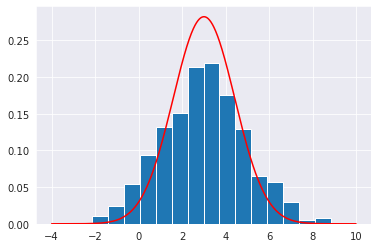

In [4]:
def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = (a + 2b - 7)^{2} + (2a + b - 5)^{2}$

In [5]:
def non_const_model(params, x):
    a, b = params
    return ((a + 2*b - 7)**2 + (2*a + b - 5)**2)

### Visualising the model described above

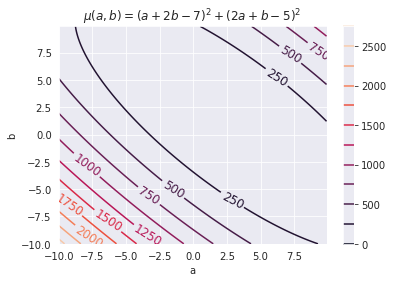

In [6]:
a = np.arange(-10, 10, .1)
b = np.arange(-10, 10, .1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)


function_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    function_values[idx] = non_const_model(val, sample)
    

contours = plt.contour(aa, bb, function_values.reshape(aa.shape), 10)
plt.clabel(contours, inline=1, fontsize=12)
plt.ylabel("b")
plt.xlabel("a")
plt.title("$\mu(a, b) = (a + 2b - 7)^{2} + (2a + b - 5)^{2}$")
plt.colorbar()

In [7]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = non_const_model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

### Visualising the -log likelihood where the model is substituted for $\mu$

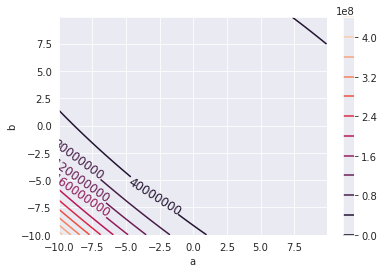

In [8]:
a = np.arange(-10, 10, .1)
b = np.arange(-10, 10, .1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

contours = plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 10)
plt.clabel(contours, inline=1, fontsize=12)
plt.ylabel("b")
plt.xlabel("a")
plt.colorbar()

### Minimising the -log likelihood

In [9]:
# initial guesses for a and b of the model
initial_guess = [-10, 10]

likelihood_sim = Simulator(likelihood)

lik_model = minimize(likelihood_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 72
         Function evaluations: 158


In [10]:
# results for each iteration of the minimisation
callback = likelihood_sim.to_dataframe()

with pd.option_context('display.max_rows',10):
    print(callback)

    parameter 1  parameter 2    likelihood  iteration
0    -10.000000    10.000000  3.336857e+06          1
1    -10.000000    10.500000  3.116804e+06          2
2     -9.500000    10.500000  2.489206e+06          3
3     -9.000000    10.750000  1.966601e+06          4
4     -8.000000    11.500000  1.431317e+06          5
..          ...          ...           ...        ...
31    -0.168221     3.612952  1.035950e+03         32
32    -0.168383     3.613293  1.035950e+03         33
33    -0.168429     3.613391  1.035950e+03         34
34    -0.168534     3.613610  1.035950e+03         35
35    -0.168533     3.613610  1.035950e+03         36

[36 rows x 4 columns]


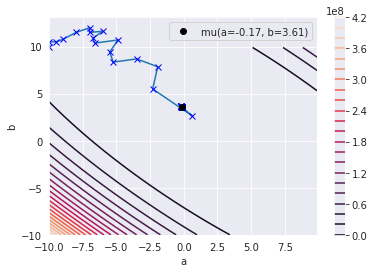

In [11]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(callback["parameter 1"], callback["parameter 2"])
plt.plot(callback["parameter 1"], callback["parameter 2"], 'bx')
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()

In [12]:
og = OutputGenerator(non_const_model, callback)

print(json.dumps(og.return_json(), sort_keys=True, indent=4))

{
    "meta_data": {
        "date": "09:42:47 19/07/2022",
        "method": "Nelder-Mead",
        "number_of_iterations": 36,
        "objective_function": "((a + 2*b - 7)**2 + (2*a + b - 5)**2)"
    },
    "results": "{\"parameter 1\":{\"0\":-10.0,\"1\":-10.0,\"2\":-9.5,\"3\":-9.0,\"4\":-8.0,\"5\":-7.0,\"6\":-7.0,\"7\":-6.0,\"8\":-6.75,\"9\":-6.625,\"10\":-4.875,\"11\":-5.5,\"12\":-5.25,\"13\":-3.5,\"14\":-1.9375,\"15\":-2.3125,\"16\":0.625,\"17\":-0.177734375,\"18\":-0.2079162598,\"19\":-0.1669092178,\"20\":-0.2082029581,\"21\":-0.1901011094,\"22\":-0.1830306258,\"23\":-0.1649287771,\"24\":-0.1772500206,\"25\":-0.1676290715,\"26\":-0.1682743539,\"27\":-0.1681935234,\"28\":-0.1684557119,\"29\":-0.1678104296,\"30\":-0.1681632971,\"31\":-0.1682212876,\"32\":-0.1683832238,\"33\":-0.1684294522,\"34\":-0.1685335344,\"35\":-0.1685334225},\"parameter 2\":{\"0\":10.0,\"1\":10.5,\"2\":10.5,\"3\":10.75,\"4\":11.5,\"5\":12.0,\"6\":11.5,\"7\":11.625,\"8\":10.90625,\"9\":10.359375,\"10\":10.703